# Pump vs Compressor for 2Ø D2C Cooling in Data Centers


## Cycle overview
![Pressue lift vs. Flow - - range where surge and choke occure ](IMG/PumpvsComp.svg)


## Hypothetical compressor in 2Ø


### PH diagram


Using backend: REFPROP::R1234ZEE

=== Key States ===
1 Evap OUT                  p=   8.761 bar  T=  45.000 °C  h=  337.447 kJ/kg  s= 1.4451 kJ/kg-K  x=0.5000
2s Pump OUT (isentr.)       p=   9.294 bar  T=  47.259 °C  h=  338.018 kJ/kg  s= 1.4451 kJ/kg-K  x=0.4885
2 Pump OUT                  p=   9.294 bar  T=  47.259 °C  h=  338.399 kJ/kg  s= 1.4463 kJ/kg-K  x=0.4911
3' Cond OUT (sat liq)       p=   9.011 bar  T=  46.073 °C  h=  263.839 kJ/kg  s=    nan kJ/kg-K  x=0.0000
4 Subcool OUT               p=   8.968 bar  T=  41.073 °C  h=  256.545 kJ/kg  s= 1.1907 kJ/kg-K  x=-998.0000
5 Valve OUT / Evap IN       p=   8.982 bar  T=  40.930 °C  h=  256.338 kJ/kg  s= 1.1900 kJ/kg-K  x=-0.0490

=== Pump ===
Δp_pump set          : 0.500 bar
w_isentropic         : 0.57121 kJ/kg
w_actual             : 0.95202 kJ/kg
η_is                 : 0.6000

=== Pressure Drops (computed Darcy–Weisbach) ===
Evaporator total Δp  : 0.2208 bar  (target ~0.3 bar; adjust m_dot/L/D/ε)
  Suction riser Δp   : 0.0325 bar

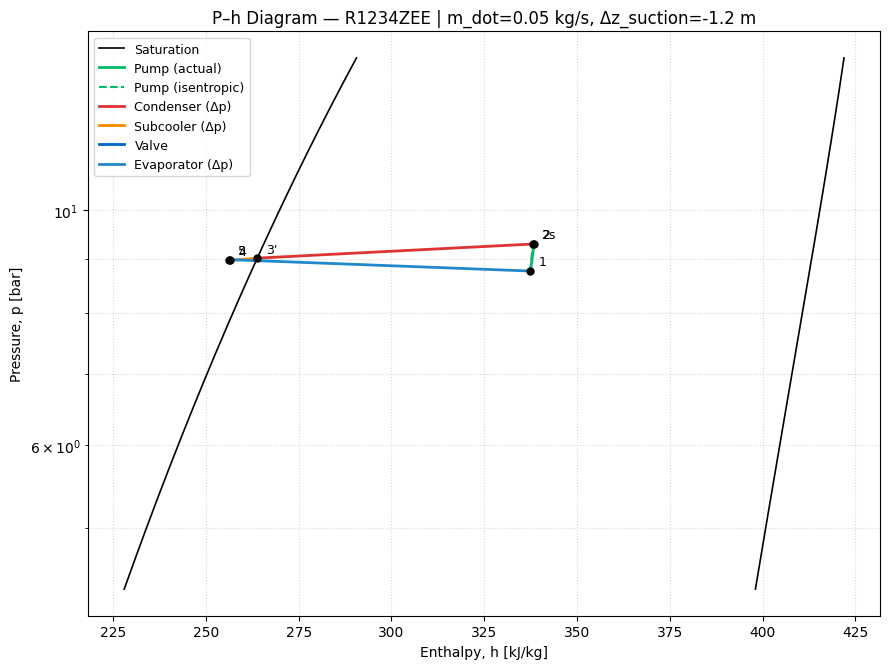

In [11]:
# %% [markdown]
# Refrigeration loop with Darcy–Weisbach pressure drops (two-phase homogeneous model)
# -----------------------------------------------------------------------------------
# Components:
#   Evaporator (two-phase DP + static head), Pump (two-phase), Condenser (two-phase DP),
#   Subcooler (liquid DP), Expansion valve (isenthalpic), and connecting pipes (DP + static head).
#
# Outputs:
#   - Key states (p, T, h, s, x)
#   - Detailed DP breakdown by component (friction + static head)
#   - P–h diagram with all paths and points
#
# Notes:
#   - Evaporator DP is computed from geometry + m_dot using Darcy–Weisbach (homogeneous model),
#     not hard-coded; tweak geometry/m_dot to get around ~0.3 bar as desired.
#   - Elevation: evaporator is 1.2 m above pump (defaults place Δz on suction riser).
#   - Pump isentropic efficiency is an input (or you can plug measured data).
#   - Backend: REFPROP via CoolProp if available, else HEOS.

# %%
import math
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

# ---------------------
# USER INPUTS
# ---------------------
fluid = "R1234ZEE"
prefer_refprop = True

# Evaporator outlet (given): two-phase at T and quality
T_evap_C = 45.0      # Adjust sign to your case (+45°C or -45°C)
x_evap_out = 0.50

# Pump
dp_pump_bar = 0.5    # Pump pressure lift [bar]
eta_pump_is = 0.60   # Pump isentropic efficiency

# Mass flow rate (needed for Darcy–Weisbach)
m_dot = 0.05         # kg/s  <-- Adjust to your system

# Geometry & roughness (typical examples; TUNE THESE)
# Evaporator tube (two-phase)
L_evap = 8.0         # m    (total equivalent length inside evaporator)
D_evap = 0.010       # m    (10 mm ID microchannel/tube)
eps_evap = 1.5e-5    # m    (roughness, e.g., drawn copper ~1.5e-6..1.5e-5 m)

# Suction line (evap OUT -> pump IN), two-phase mix near 1
L_suction = 2.0      # m
D_suction = 0.012    # m
eps_suction = 1.5e-5 # m
dz_suction = -1.2    # m   (negative: going DOWN from evaporator to pump; increases pressure at pump)

# Discharge line (pump OUT -> condenser IN), two-phase at inlet
L_discharge = 2.0    # m
D_discharge = 0.012  # m
eps_discharge = 1.5e-5
dz_discharge = 0.0   # m

# Condenser tubes (two-phase -> sat. liquid)
L_cond = 10.0        # m
D_cond = 0.010       # m
eps_cond = 1.5e-5
dz_cond = 0.0        # m

# Subcooler / liquid line (single-phase liquid)
L_liquid = 3.0       # m
D_liquid = 0.008     # m
eps_liquid = 1.5e-5
dz_liquid = 0.0      # m

# Target subcooling at subcooler outlet
DT_subcool_K = 5.0

# Plot options
save_fig = False
fig_path = "Ph_diagram_Darcy.png"
dpi = 160

# ---------------------
# Backend selection
# ---------------------
def pick_backend(fluid_name: str, prefer_refprop=True):
    backend = fluid_name
    if prefer_refprop:
        try:
            _ = PropsSI("T", "P", 101325.0, "Q", 0.5, "REFPROP::" + fluid_name)
            backend = "REFPROP::" + fluid_name
        except Exception:
            backend = fluid_name
    return backend

backend = pick_backend(fluid, prefer_refprop)
print(f"Using backend: {backend}")

# ---------------------
# Thermo utilities
# ---------------------
def st_TX(T_C, x):
    T_K = T_C + 273.15
    p = PropsSI("P", "T", T_K, "Q", x, backend)
    h = PropsSI("H", "T", T_K, "Q", x, backend)
    s = PropsSI("S", "T", T_K, "Q", x, backend)
    return {"T": T_K, "p": p, "h": h, "s": s, "x": x}

def st_pS(p, s):
    T = PropsSI("T", "P", p, "S", s, backend)
    h = PropsSI("H", "P", p, "S", s, backend)
    try:
        x = PropsSI("Q", "P", p, "S", s, backend)
    except Exception:
        x = float("nan")
    return {"T": T, "p": p, "h": h, "s": s, "x": x}

def st_pT(p, T_K):
    h = PropsSI("H", "P", p, "T", T_K, backend)
    s = PropsSI("S", "P", p, "T", T_K, backend)
    try:
        x = PropsSI("Q", "P", p, "T", T_K, backend)
    except Exception:
        x = float("nan")
    return {"T": T_K, "p": p, "h": h, "s": s, "x": x}

def st_pH(p, h):
    T = PropsSI("T", "P", p, "H", h, backend)
    s = PropsSI("S", "P", p, "H", h, backend)
    try:
        x = PropsSI("Q", "P", p, "H", h, backend)
    except Exception:
        x = float("nan")
    return {"T": T, "p": p, "h": h, "s": s, "x": x}

def hL(p): return PropsSI("H", "P", p, "Q", 0.0, backend)
def hV(p): return PropsSI("H", "P", p, "Q", 1.0, backend)
def Tsat(p): return PropsSI("T", "P", p, "Q", 0.0, backend)
def rhoL(p): return PropsSI("D", "P", p, "Q", 0.0, backend)
def rhoV(p): return PropsSI("D", "P", p, "Q", 1.0, backend)
def muL(p):  return PropsSI("VISCOSITY", "P", p, "Q", 0.0, backend)  # Pa·s
def muV(p):  return PropsSI("VISCOSITY", "P", p, "Q", 1.0, backend)  # Pa·s

# ---------------------
# Hydraulics utilities (Darcy–Weisbach)
# ---------------------
g = 9.80665
bar2Pa = 1e5

def haaland_f(Re, rel_eps):
    """Darcy friction factor (Haaland explicit approximation)."""
    if Re < 1e-9:
        return 0.0
    # If laminar, f = 64/Re
    if Re < 2300.0:
        return 64.0/Re
    # Turbulent (Haaland)
    A = (rel_eps/3.7)**1.11 + 6.9/Re
    return ( -1.8*np.log10(A) )**-2

def two_phase_mixture_props(p, x):
    """Homogeneous model mixture properties at pressure p and quality x."""
    x = min(max(x, 0.0), 1.0)
    rL, rV = rhoL(p), rhoV(p)
    mL, mV = muL(p), muV(p)
    # Mixture density (void fraction with slip=1)
    rho_m = 1.0 / (x/rV + (1.0-x)/rL)
    # Mixture viscosity (Cicchitti)
    mu_m = mL*(1.0-x) + mV*x
    return rho_m, mu_m, rL, rV, mL, mV

def dp_friction_DW(m_dot, rho, mu, L, D, eps):
    """Single-phase Darcy–Weisbach pressure drop [Pa]."""
    A = 0.25*np.pi*D*D
    v = m_dot/(rho*A)
    Re = rho*v*D/mu if mu > 0 else 1e9
    f = haaland_f(Re, eps/D)
    dp = f*(L/D)*(rho*v*v/2.0)
    return dp, f, Re, v

def dp_two_phase_homogeneous(m_dot, p_in, p_out, x_in, x_out, L, D, eps, N=50, dz=0.0):
    """
    Two-phase DP using homogeneous model along a segment with varying quality and pressure.
    Integrates friction + static head over N slices from inlet to outlet.
    """
    # Assume linear variation of p and x
    ps = np.linspace(p_in, p_out, N)
    xs = np.linspace(x_in, x_out, N)
    A = 0.25*np.pi*D*D
    dp_fric = 0.0
    dp_static = 0.0
    # Distribute dz uniformly
    dz_i = dz/ (N-1) if N > 1 else dz
    for i in range(N-1):
        p_mid = 0.5*(ps[i]+ps[i+1])
        x_mid = 0.5*(xs[i]+xs[i+1])
        rho_m, mu_m, *_ = two_phase_mixture_props(p_mid, x_mid)
        v = m_dot/(rho_m*A)
        Re = rho_m*v*D/mu_m if mu_m>0 else 1e9
        f = haaland_f(Re, eps/D)
        dL = L/(N-1)
        dp_fric += f*(dL/D)*(rho_m*v*v/2.0)
        dp_static += rho_m*g*dz_i  # positive if flowing up (pressure drop)
    return dp_fric + dp_static, dp_fric, dp_static

def dp_single_phase(m_dot, p_ref, T_ref, L, D, eps, dz=0.0):
    """Single-phase DP (liquid) at given reference p,T for properties."""
    rho = PropsSI("D", "P", p_ref, "T", T_ref, backend)
    mu  = PropsSI("VISCOSITY", "P", p_ref, "T", T_ref, backend)
    dp_f, f, Re, v = dp_friction_DW(m_dot, rho, mu, L, D, eps)
    dp_stat = rho*g*dz if dz != 0 else 0.0
    return dp_f + dp_stat, dp_f, dp_stat, f, Re, v, rho, mu

# ---------------------
# 1) Set key thermodynamic states ignoring DPs first
# ---------------------
st1 = st_TX(T_evap_C, x_evap_out)         # Evap OUT
p1 = st1["p"]

# Pump outlet pressure
p2 = p1 + dp_pump_bar*bar2Pa

# Isentropic pump outlet (for isentropic work)
st2s = st_pS(p2, st1["s"])
w_is = st2s["h"] - st1["h"]
w_act = w_is/eta_pump_is
st2 = st_pH(p2, st1["h"] + w_act)

# ---------------------
# 2) Build condenser + subcooler + valve path with DPs from hydraulics
#     We'll iterate condenser DP because the outlet pressure p3 depends on it.
# ---------------------
# First, guess condenser DP with a small initial value, then iterate
p_tolerance = 50.0  # Pa
p3 = p2 - 0.2*bar2Pa  # initial guess of 0.2 bar drop
for _ in range(8):
    # State 3' sat liq at p3
    st3p = {"p": p3, "T": Tsat(p3), "h": hL(p3), "x": 0.0}
    # Subcooler outlet 4 at p4 = p3 - DP_liquid (unknown yet); loop later after liquid DP
    # For two-phase condenser tube DP, we need inlet quality at 2:
    try:
        x2 = PropsSI("Q", "P", p2, "H", st2["h"], backend)
    except Exception:
        x2 = float("nan")
    # If x2 not in [0,1], treat desuperheating small portion; assume saturation reached quickly then condense
    x2_eff = np.clip(0.9 if not np.isfinite(x2) else x2, 0.0, 1.0)
    # Two-phase DP from (p2, x2_eff) -> (p3, 0)
    dp_cond, dp_cond_f, dp_cond_stat = dp_two_phase_homogeneous(
        m_dot, p2, p3, x2_eff, 0.0, L_cond, D_cond, eps_cond, N=60, dz=dz_cond
    )
    p3_new = p2 - dp_cond
    if abs(p3_new - p3) < p_tolerance:
        p3 = p3_new
        break
    p3 = 0.5*(p3 + p3_new)

# Now subcooler/liquid line from 3' to 4 with single-phase DP and target subcooling
T4 = Tsat(p3) - DT_subcool_K
# Iterate liquid line DP because p4 depends on it and properties depend on p,T
p4 = p3 - 0.05*bar2Pa
for _ in range(5):
    dp_liq_total, dp_liq_f, dp_liq_stat, fL, ReL, vL, rhoL_sc, muL_sc = dp_single_phase(
        m_dot, 0.5*(p3+p4), 0.5*(Tsat(p3)+T4), L_liquid, D_liquid, eps_liquid, dz=dz_liquid
    )
    p4_new = p3 - dp_liq_total
    if abs(p4_new - p4) < p_tolerance:
        p4 = p4_new
        break
    p4 = 0.5*(p4 + p4_new)
st4 = st_pT(p4, T4)

# Valve: 4 -> 5, isenthalpic to the evaporator inlet pressure (unknown yet; determined by evap DP)
h5 = st4["h"]

# ---------------------
# 3) Low-side hydraulics: suction line + evaporator (computes p5 and dp_evap)
#     We include 1.2 m elevation on the suction riser (evap OUT -> pump IN).
# ---------------------
# Suction riser (two-phase near x≈x_evap_out): compute DP from evap OUT down to pump IN
# We'll need pump inlet pressure (unknown); for suction DP we need p at both ends.
# Approach: estimate suction DP using properties near p1 and quality near x_evap_out; then set pump inlet pressure.
x_suction_avg = x_evap_out
dp_suction, dp_suct_f, dp_suct_stat = dp_two_phase_homogeneous(
    m_dot, p1, p1, x_suction_avg, x_suction_avg, L_suction, D_suction, eps_suction, N=20, dz=dz_suction
)
# Since we set p_in=p_out in the function (properties only), take computed dp as the required pressure difference
p_pump_in = p1 + dp_suction  # adds (negative dz) static head (pressure gain) minus friction

# Pump outlet was fixed by dp_pump_bar
p2 = p_pump_in + dp_pump_bar*bar2Pa
# Recompute 2s/2 with updated p2 (slight change if p_pump_in != p1)
st2s = st_pS(p2, st1["s"])
w_is = st2s["h"] - st1["h"]
w_act = w_is/eta_pump_is
st2 = st_pH(p2, st1["h"] + w_act)

# Recompute condenser DP and p3 with updated p2
p3 = p2 - 0.2*bar2Pa
for _ in range(8):
    try:
        x2 = PropsSI("Q", "P", p2, "H", st2["h"], backend)
    except Exception:
        x2 = float("nan")
    x2_eff = np.clip(0.9 if not np.isfinite(x2) else x2, 0.0, 1.0)
    dp_cond, dp_cond_f, dp_cond_stat = dp_two_phase_homogeneous(
        m_dot, p2, p3, x2_eff, 0.0, L_cond, D_cond, eps_cond, N=60, dz=dz_cond
    )
    p3_new = p2 - dp_cond
    if abs(p3_new - p3) < p_tolerance:
        p3 = p3_new
        break
    p3 = 0.5*(p3 + p3_new)

# Subcooler/liquid line again with updated p3
T4 = Tsat(p3) - DT_subcool_K
p4 = p3 - 0.05*bar2Pa
for _ in range(5):
    dp_liq_total, dp_liq_f, dp_liq_stat, fL, ReL, vL, rhoL_sc, muL_sc = dp_single_phase(
        m_dot, 0.5*(p3+p4), 0.5*(Tsat(p3)+T4), L_liquid, D_liquid, eps_liquid, dz=dz_liquid
    )
    p4_new = p3 - dp_liq_total
    if abs(p4_new - p4) < p_tolerance:
        p4 = p4_new
        break
    p4 = 0.5*(p4 + p4_new)
st4 = st_pT(p4, T4)

# Now the evaporator inlet pressure p5 is determined by expansion from p4 to p5 (h = const) AND
# the evaporator+connecting low-side DP from p5 (in) to p1 (out). We'll iterate for p5.
p5 = p1 + 0.3*bar2Pa  # start with your ~0.3 bar target
for _ in range(12):
    # Valve sets state at (p5, h=st4.h)
    st5 = st_pH(p5, h5)
    # Quality at evaporator inlet (two-phase)
    try:
        x5 = PropsSI("Q", "P", st5["p"], "H", st5["h"], backend)
    except Exception:
        # If not two-phase (rare), clamp to saturated line enthalpy-based quality
        x5 = np.nan
    if not np.isfinite(x5):
        # Estimate x5 from lever rule at p5
        hL5, hV5 = hL(p5), hV(p5)
        x5 = np.clip((st5["h"] - hL5) / max(hV5 - hL5, 1e-6), 0.0, 1.0)

    # Evaporator DP from (p5, x5) to (p1, x_out)
    dp_evap_total, dp_evap_f, dp_evap_stat = dp_two_phase_homogeneous(
        m_dot, p5, p1, x5, x_evap_out, L_evap, D_evap, eps_evap, N=60, dz=0.0
    )
    # Also include any low-side horizontal line from valve to evap inlet if you want (here assumed negligible)
    # Closure: p5 should equal p1 + dp_evap_total
    p5_new = p1 + dp_evap_total
    if abs(p5_new - p5) < p_tolerance:
        p5 = p5_new
        break
    p5 = 0.5*(p5 + p5_new)

# Final states with converged pressures
st5 = st_pH(p5, h5)
states = {
    "1 Evap OUT": st1,
    "2s Pump OUT (isentr.)": st2s,
    "2 Pump OUT": st2,
    "3' Cond OUT (sat liq)": {"p": p3, "T": Tsat(p3), "h": hL(p3), "s": np.nan, "x": 0.0},
    "4 Subcool OUT": st4,
    "5 Valve OUT / Evap IN": st5,
}

# Duties and pump numbers
q_evap_kJkg = (st1["h"] - st5["h"])/1e3
q_cond_kJkg = ((st2["h"] - hL(p3)) + (hL(p3) - st4["h"])) / 1e3
w_is_kJkg = (st2s["h"] - st1["h"])/1e3
w_act_kJkg = (st2["h"] - st1["h"])/1e3
eta_is_assessed = w_is_kJkg / w_act_kJkg if w_act_kJkg>0 else np.nan

# DP summary
dp_evap_bar = (p5 - p1)/bar2Pa
dp_cond_bar = (p2 - p3)/bar2Pa
dp_liq_bar  = (p3 - p4)/bar2Pa
dp_suct_bar = dp_suction/bar2Pa

# ---------------------
# Print key results
# ---------------------
def fmt_state(name, st):
    p_bar = st["p"]/1e5
    T_C = st["T"] - 273.15
    h_kJkg = st["h"]/1e3
    try:
        s_kJkgK = st["s"]/1e3
    except Exception:
        s_kJkgK = np.nan
    x = st.get("x", float("nan"))
    xs = "N/A" if (not np.isfinite(x)) else f"{x:0.4f}"
    return f"{name:<27s} p={p_bar:8.3f} bar  T={T_C:8.3f} °C  h={h_kJkg:9.3f} kJ/kg  s={s_kJkgK:7.4f} kJ/kg-K  x={xs}"

print("\n=== Key States ===")
for k, v in states.items():
    print(fmt_state(k, v))

print("\n=== Pump ===")
print(f"Δp_pump set          : {dp_pump_bar:.3f} bar")
print(f"w_isentropic         : {w_is_kJkg:.5f} kJ/kg")
print(f"w_actual             : {w_act_kJkg:.5f} kJ/kg")
print(f"η_is                 : {eta_is_assessed:.4f}")

print("\n=== Pressure Drops (computed Darcy–Weisbach) ===")
print(f"Evaporator total Δp  : {dp_evap_bar:.4f} bar  (target ~0.3 bar; adjust m_dot/L/D/ε)")
print(f"  Suction riser Δp   : {dp_suct_bar:.4f} bar  (two-phase friction + static head with Δz={dz_suction} m)")
print(f"Condenser Δp         : {dp_cond_bar:.4f} bar  (two-phase, homogeneous)")
print(f"Liquid line Δp       : {dp_liq_bar:.4f} bar  (single-phase liquid)")

print("\n=== Duties per kg ===")
print(f"q_evap               : {q_evap_kJkg:.3f} kJ/kg")
print(f"q_cond               : {q_cond_kJkg:.3f} kJ/kg")

# ---------------------
# Build P–h diagram with paths
# ---------------------
# Saturation dome
p_min = max(PropsSI("P_MIN","",0,"",0,backend), min(s['p'] for s in states.values())*0.5)
p_max = min(PropsSI("P_MAX","",0,"",0,backend), max(s['p'] for s in states.values())*1.5)
p_sat = np.geomspace(max(p_min,1e3), p_max, 350)
hL_sat = np.array([hL(pi) for pi in p_sat])
hV_sat = np.array([hV(pi) for pi in p_sat])

# Paths
# Pump path (1->2 actual) and (1->2s)
h_pump = [st1["h"]/1e3, st2["h"]/1e3]
p_pump = [st1["p"]/1e5, st2["p"]/1e5]
h_pump_s = [st1["h"]/1e3, st2s["h"]/1e3]
p_pump_s = [st1["p"]/1e5, st2s["p"]/1e5]

# Condenser (two-phase) from 2 to 3'
N_cond_plot = 60
p_cond_path = np.linspace(st2["p"], p3, N_cond_plot)
# Inlet quality near x2_eff, then go to 0
try:
    x2 = PropsSI("Q", "P", st2["p"], "H", st2["h"], backend)
except Exception:
    x2 = np.nan
x2_eff = np.clip(0.9 if not np.isfinite(x2) else x2, 0.0, 1.0)
x_path_cond = np.linspace(x2_eff, 0.0, N_cond_plot)
h_cond_path = []
for pi, xi in zip(p_cond_path, x_path_cond):
    h_cond_path.append(hL(pi) + xi*(hV(pi)-hL(pi)))
h_cond_path = np.array(h_cond_path)/1e3

# Subcooler (3'->4)
N_sc = 12
p_sc_path = np.linspace(p3, p4, N_sc)/1e5
h_sc_path = np.linspace(hL(p3)/1e3, st4["h"]/1e3, N_sc)

# Valve (4->5), isenthalpic
p_valve = np.linspace(p4, p5, 12)/1e5
h_valve = np.full_like(p_valve, st4["h"]/1e3)

# Evaporator (5->1)
N_evap_plot = 60
p_evap_path = np.linspace(p5, p1, N_evap_plot)
# Quality from x5 -> x_out
try:
    x5_plot = PropsSI("Q","P",st5["p"],"H",st5["h"], backend)
except Exception:
    hL5, hV5 = hL(p5), hV(p5)
    x5_plot = np.clip((st5["h"]-hL5)/max(hV5-hL5,1e-6), 0.0, 1.0)
x_evap_path = np.linspace(x5_plot, x_evap_out, N_evap_plot)
h_evap_path = []
for pi, xi in zip(p_evap_path, x_evap_path):
    h_evap_path.append(hL(pi) + xi*(hV(pi)-hL(pi)))
p_evap_plot = p_evap_path/1e5
h_evap_plot = np.array(h_evap_path)/1e3

# Plot
plt.figure(figsize=(9, 6.8))
plt.plot(hL_sat/1e3, p_sat/1e5, 'k-', lw=1.2)
plt.plot(hV_sat/1e3, p_sat/1e5, 'k-', lw=1.2, label="Saturation")

plt.plot(h_pump, p_pump, color="#0b6", lw=2.0, label="Pump (actual)")
plt.plot(h_pump_s, p_pump_s, color="#0b6", ls="--", lw=1.5, label="Pump (isentropic)")
plt.plot(h_cond_path, p_cond_path/1e5, color="#d33", lw=2.0, label="Condenser (Δp)")
plt.plot(h_sc_path, p_sc_path, color="#f80", lw=2.0, label="Subcooler (Δp)")
plt.plot(h_valve, p_valve, color="#06c", lw=2.0, label="Valve")
plt.plot(h_evap_plot, p_evap_plot, color="#28c", lw=2.0, label="Evaporator (Δp)")

# Markers
markers = {"1": st1, "2": st2, "2s": st2s, "3'": states["3' Cond OUT (sat liq)"], "4": st4, "5": st5}
for tag, st in markers.items():
    plt.plot(st["h"]/1e3, st["p"]/1e5, 'ko', ms=5)
    plt.annotate(tag, (st["h"]/1e3, st["p"]/1e5), textcoords="offset points", xytext=(6, 4), fontsize=9)

plt.yscale("log")
plt.xlabel("Enthalpy, h [kJ/kg]")
plt.ylabel("Pressure, p [bar]")
plt.title(f"P–h Diagram — {fluid} | m_dot={m_dot} kg/s, Δz_suction={dz_suction} m")
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.legend(loc="best", fontsize=9)

if save_fig:
    plt.tight_layout()
    plt.savefig(fig_path, dpi=dpi)
plt.tight_layout()


## Pump 2Ø System

### Performance & PH diagram.


Using backend: REFPROP::R1234ZEE

=== Design Summary (5 kW target) ===
Fluid                       : R1234ZEE (backend: REFPROP::R1234ZEE)
Evaporator outlet           : T = 45.00 °C, x = 0.500
Target cooling capacity     : 5.000 kW
Converged mass flow         : 0.05909 kg/s
Delivered cooling           : 4.995 kW
Pump Δp (delivered)         : 0.7716 bar
Pump hydraulic power        : 4.08 W
Pump shaft/electric power   : 5.83 W  (η = 0.70)
Cooling COP (Q/W_shaft)     : 857.145
Recommended evaporator D    : 10.0 mm
Recommended evaporator L    : 8.0 m
Resulting evap Δp           : 0.3330 bar (target 0.300 bar)

=== Pressure Drops & Pump Head (Darcy–Weisbach + static head) ===
Return (evap→cond) Δp :   0.0357 bar (two-phase)
Condenser Δp          :   0.2825 bar (two-phase to sat liq)
Subcooler/liquid Δp   :   0.0435 bar (single-phase)
Control valve Δp      :   0.0500 bar (assigned)
Evaporator Δp         :   0.2208 bar (two-phase, includes +1.2 m static head)
Pump delivered Δp     :   0.5000 

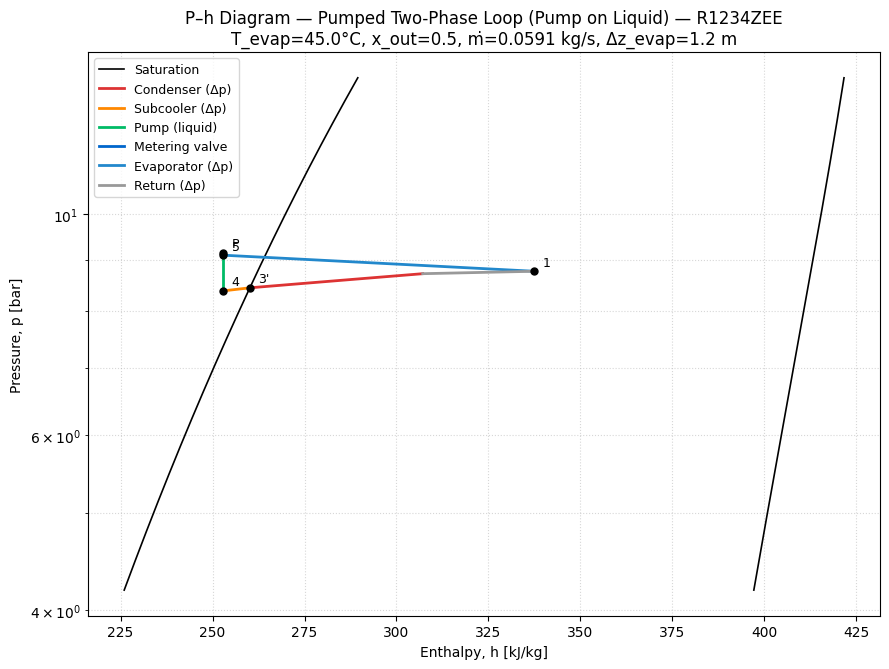

In [12]:
# -*- coding: utf-8 -*-
# pumped_two_phase_loop_5kW.txt (Python code saved as .txt per user request)
# ---------------------------------------------------------------------------
# Purpose:
#   Size tube(s) and compute mass flow to deliver ~5 kW cooling in an evaporator
#   for a pumped two-phase refrigeration/thermal loop where the PUMP IS ON THE
#   LIQUID LINE (post-condenser). The pump overcomes friction + control-valve
#   loss and static head; it does not create a high/low side like a compressor.
#
# What this script does:
#   1) Uses CoolProp (optionally REFPROP backend) to get thermo properties.
#   2) Given evaporator outlet condition (T_evap, x_out), and a target cooling
#      capacity Q_cool_target (e.g., 5 kW), it iterates the MASS FLOW RATE m_dot
#      so that m_dot * (h1 - h5) ≈ Q_cool_target.
#   3) Computes Darcy–Weisbach pressure drops (single-phase & two-phase using a
#      homogeneous model) including static head (+1.2 m evaporator above pump).
#   4) Iterates pump discharge pressure so the evaporator pressure drop closes
#      back to the known evaporator outlet pressure (set by T_evap, x_out).
#   5) Searches candidate evaporator tube sizes (D, L) to hit a target
#      evaporator Δp ≈ 0.3 bar for the converged mass flow, then recomputes the
#      loop with the recommended size.
#   6) Prints a concise table: COP_cooling, Q_cool (kW), m_dot (kg/s), pump Δp,
#      pump power, and recommended tube size. Also prints a state table.
#   7) (Optional) Plots a P–h diagram; toggle with PLOT_PH = True.
#
# Notes:
#   - Set T_evap_C to your application (e.g., -5.0 °C); the default here keeps
#     45.0 °C from earlier drafts—please adjust as needed.
#   - Requires: CoolProp, numpy, matplotlib.
#   - If REFPROP is installed, the script will try to use it via CoolProp.
#
# Author: Generated by M365 Copilot
# ---------------------------------------------------------------------------

import math
import numpy as np
import sys

PLOT_PH = True  # set False to skip plotting

try:
    import matplotlib.pyplot as plt
except Exception:
    PLOT_PH = False

try:
    from CoolProp.CoolProp import PropsSI
    HAVE_COOLPROP = True
except Exception as e:
    HAVE_COOLPROP = False
    sys.stderr.write("CoolProp is required for this script. Install with: pip install CoolProp\n")
    raise

# ---------------------
# USER INPUTS
# ---------------------
fluid = "R1234ZEE"           # Refrigerant string (REFPROP alias should match if used)
prefer_refprop = True      # Try REFPROP backend if available

T_evap_C = 45.0            # Evaporator outlet temperature (°C). Adjust sign as needed (+/-)
x_evap_out = 0.50          # Evaporator outlet quality
Q_cool_target_W = 5000.0   # Target cooling capacity [W] (5 kW)

# Static head: evaporator is above pump
z_evap_above_pump_m = 1.2  # [m]

# Control valve fixed small pressure drop (can set to 0.0)
dp_valve_bar = 0.05

# Initial guess for mass flow [kg/s] (will be iterated)
m_dot_guess = 0.05

# Subcooling at subcooler outlet (pump inlet)
DT_subcool_K = 5.0

# Pump efficiency (electric-to-hydraulic)
eta_pump = 0.70

# Geometry & roughness (initial; evaporator D & L will be optimized later)
# Condenser (two-phase to sat. liquid)
L_cond = 10.0       # m
D_cond = 0.010      # m
eps_cond = 1.5e-5   # m

# Subcooler / liquid line (single-phase liquid)
L_subcool = 3.0     # m
D_subcool = 0.008   # m
eps_subcool = 1.5e-5

# Return line (two-phase) from evaporator OUT back to condenser IN
L_return = 2.0      # m
D_return = 0.012    # m
eps_return = 1.5e-5

# Evaporator elevation is applied within the evaporator segment (+z increases DP)
# Candidate evaporator tube sizes for targeting ~0.3 bar DP at converged mass flow
candidate_D_evap = [0.006, 0.008, 0.010, 0.012, 0.014]  # meters (6–14 mm ID)
candidate_L_evap = [4.0, 6.0, 8.0, 10.0, 12.0]          # meters

evap_dp_target_bar = 0.30

# Plot / export options
save_fig = False
fig_path = "Ph_pumped_loop_5kW.png"
dpi = 160

# ---------------------
# Backend picker (REFPROP via CoolProp if available)
# ---------------------
def pick_backend(fluid_name: str, prefer_refprop=True):
    backend = fluid_name
    if prefer_refprop:
        try:
            _ = PropsSI("T", "P", 101325.0, "Q", 0.5, "REFPROP::" + fluid_name)
            backend = "REFPROP::" + fluid_name
        except Exception:
            backend = fluid_name
    return backend

backend = pick_backend(fluid, prefer_refprop)
print(f"Using backend: {backend}")

# ---------------------
# Thermo helpers
# ---------------------
def st_TX(T_C, x):
    T_K = T_C + 273.15
    p = PropsSI("P", "T", T_K, "Q", x, backend)
    h = PropsSI("H", "T", T_K, "Q", x, backend)
    s = PropsSI("S", "T", T_K, "Q", x, backend)
    return {"T": T_K, "p": p, "h": h, "s": s, "x": x}

def st_pT(p, T_K):
    h = PropsSI("H", "P", p, "T", T_K, backend)
    s = PropsSI("S", "P", p, "T", T_K, backend)
    try:
        x = PropsSI("Q", "P", p, "T", T_K, backend)
    except Exception:
        x = float("nan")
    return {"T": T_K, "p": p, "h": h, "s": s, "x": x}

def st_pH(p, h):
    T = PropsSI("T", "P", p, "H", h, backend)
    s = PropsSI("S", "P", p, "H", h, backend)
    try:
        x = PropsSI("Q", "P", p, "H", h, backend)
    except Exception:
        x = float("nan")
    return {"T": T, "p": p, "h": h, "s": s, "x": x}

def hL(p): return PropsSI("H", "P", p, "Q", 0.0, backend)
def hV(p): return PropsSI("H", "P", p, "Q", 1.0, backend)
def Tsat(p): return PropsSI("T", "P", p, "Q", 0.0, backend)
def rhoL(p): return PropsSI("D", "P", p, "Q", 0.0, backend)
def rhoV(p): return PropsSI("D", "P", p, "Q", 1.0, backend)
def muL(p):  return PropsSI("VISCOSITY", "P", p, "Q", 0.0, backend)
def muV(p):  return PropsSI("VISCOSITY", "P", p, "Q", 1.0, backend)

# ---------------------
# Hydraulics (Darcy–Weisbach) with homogeneous two-phase model
# ---------------------
g = 9.80665
bar2Pa = 1e5

def haaland_f(Re, rel_eps):
    if Re < 1e-12:
        return 0.0
    if Re < 2300.0:
        return 64.0 / Re
    A = (rel_eps / 3.7) ** 1.11 + 6.9 / Re
    return (-1.8 * np.log10(A)) ** -2

def dp_friction_DW(m_dot, rho, mu, L, D, eps):
    A = 0.25 * np.pi * D * D
    v = m_dot / (rho * A)
    Re = rho * v * D / max(mu, 1e-12)
    f = haaland_f(Re, eps / D)
    dp = f * (L / D) * (rho * v * v / 2.0)
    return dp, f, Re, v

def two_phase_mix_props(p, x):
    x = float(np.clip(x, 0.0, 1.0))
    rL, rV = rhoL(p), rhoV(p)
    mL, mV = muL(p), muV(p)
    rho_m = 1.0 / (x / rV + (1.0 - x) / rL)
    mu_m = mL * (1.0 - x) + mV * x
    return rho_m, mu_m

def dp_two_phase_homogeneous(m_dot, p_in, p_out, x_in, x_out, L, D, eps, dz=0.0, N=60):
    ps = np.linspace(p_in, p_out, N)
    xs = np.linspace(x_in, x_out, N)
    A = 0.25 * np.pi * D * D
    dp_fric = 0.0
    dp_stat = 0.0
    dL = L / max(N - 1, 1)
    dz_i = dz / max(N - 1, 1) if N > 1 else dz
    for i in range(N - 1):
        p_mid = 0.5 * (ps[i] + ps[i + 1])
        x_mid = 0.5 * (xs[i] + xs[i + 1])
        rho_m, mu_m = two_phase_mix_props(p_mid, x_mid)
        v = m_dot / (rho_m * A)
        Re = rho_m * v * D / max(mu_m, 1e-12)
        f = haaland_f(Re, eps / D)
        dp_fric += f * (dL / D) * (rho_m * v * v / 2.0)
        dp_stat += rho_m * g * dz_i
    return dp_fric + dp_stat, dp_fric, dp_stat

# ---------------------
# Core loop solver
# ---------------------
def solve_loop_for_mdot(m_dot, geom, inputs):
    """Given m_dot and geometry, compute states, pressures, and performance.
    Returns dict with states, pressures, dp breakdown, q_evap, etc.
    """
    D_evap = geom["D_evap"]
    L_evap = geom["L_evap"]

    # 1) Evaporator outlet defines saturation pressure (approximately)
    st1 = st_TX(inputs["T_evap_C"], inputs["x_evap_out"])  # Evap OUT
    p1 = st1["p"]

    # 2) Return line (1 → condenser IN): two-phase DP; assume quality decreases slightly
    x_ret_in, x_ret_out = inputs["x_evap_out"], max(0.2, inputs["x_evap_out"] - 0.2)
    dp_ret, _, _ = dp_two_phase_homogeneous(
        m_dot, p1, p1, x_ret_in, x_ret_out, L_return, D_return, eps_return, dz=0.0
    )
    p_cond_in = p1 - dp_ret

    # 3) Condenser to sat. liquid at outlet p3; iterate two-phase DP
    p3 = p_cond_in - 0.1 * bar2Pa
    for _ in range(8):
        dp_cond, _, _ = dp_two_phase_homogeneous(
            m_dot, p_cond_in, p3, x_ret_out, 0.0, L_cond, D_cond, eps_cond, dz=0.0
        )
        p3_new = p_cond_in - dp_cond
        if abs(p3_new - p3) < 50.0:
            p3 = p3_new
            break
        p3 = 0.5 * (p3 + p3_new)
    st3p = {"p": p3, "T": Tsat(p3), "h": hL(p3), "s": float("nan"), "x": 0.0}

    # 4) Subcooler/liquid line 3'→4
    T4 = Tsat(p3) - inputs["DT_subcool_K"]
    # Iterate p4 because properties depend on p,T
    p4 = p3 - 0.05 * bar2Pa
    for _ in range(6):
        # Evaluate at mean conditions
        p_ref = 0.5 * (p3 + p4)
        T_ref = 0.5 * (Tsat(p3) + T4)
        rho = PropsSI("D", "P", p_ref, "T", T_ref, backend)
        mu = PropsSI("VISCOSITY", "P", p_ref, "T", T_ref, backend)
        dp_f, fL, ReL, vL = dp_friction_DW(m_dot, rho, mu, L_subcool, D_subcool, eps_subcool)
        dp_stat = rho * g * 0.0
        dp_sc = dp_f + dp_stat
        p4_new = p3 - dp_sc
        if abs(p4_new - p4) < 50.0:
            p4 = p4_new
            break
        p4 = 0.5 * (p4 + p4_new)
    st4 = st_pT(p4, T4)  # Pump inlet (subcooled liquid)

    # 5) Pump discharge pressure is solved so that evap outlet returns to p1
    dp_valve = inputs["dp_valve_bar"] * bar2Pa
    p_after_pump = p4 + 0.2 * bar2Pa
    for _ in range(12):
        p5 = p_after_pump - dp_valve
        # Valve modeled isenthalpic
        h5 = st4["h"]
        st5 = st_pH(p5, h5)
        # Quality at evap inlet
        try:
            x5 = PropsSI("Q", "P", st5["p"], "H", st5["h"], backend)
        except Exception:
            hL5, hV5 = hL(p5), hV(p5)
            x5 = float(np.clip((st5["h"] - hL5) / max(hV5 - hL5, 1e-9), 0.0, 1.0))
        # Evaporator DP from (p5,x5) to (p1,x_out) with elevation +z
        dp_evap, dp_evap_f, dp_evap_stat = dp_two_phase_homogeneous(
            m_dot, p5, p1, x5, inputs["x_evap_out"], L_evap, D_evap, geom["eps_evap"], dz=geom["dz_evap"]
        )
        p_out = p5 - dp_evap
        err = p_out - p1
        if abs(err) < 50.0:
            break
        p_after_pump -= 0.5 * err
    # Finalize states
    st5 = st_pH(p5, h5)
    st_pump_in = st4
    st_pump_out = st_pH(p_after_pump, st4["h"])  # neglect slight liquid enthalpy rise

    # 6) Cooling per kg and pump power
    q_evap = st1["h"] - st5["h"]  # J/kg
    Q_cool_W = m_dot * q_evap
    # Pump Δp and hydraulic power
    dp_pump = p_after_pump - p4
    rho_liq = PropsSI("D", "P", 0.5 * (p4 + p_after_pump), "T", st4["T"], backend)
    P_hyd = (m_dot / max(rho_liq, 1e-9)) * dp_pump  # W
    P_shaft = P_hyd / max(inputs["eta_pump"], 1e-6)
    COP = Q_cool_W / max(P_shaft, 1e-9)

    # Pack results
    states = {
        "1 Evap OUT": st1,
        "3' Cond OUT (sat liq)": st3p,
        "4 Subcool OUT / Pump IN": st_pump_in,
        "P Pump OUT (liquid)": st_pump_out,
        "5 Valve OUT / Evap IN": st5,
    }

    results = {
        "states": states,
        "p_cond_in": p_cond_in,
        "p3": p3,
        "p4": p4,
        "p_after_pump": p_after_pump,
        "p5": p5,
        "dp_return": dp_ret,
        "dp_evap": dp_evap,
        "dp_evap_f": dp_evap_f,
        "dp_evap_stat": dp_evap_stat,
        "dp_cond": p_cond_in - p3,
        "dp_subcool": p3 - p4,
        "dp_valve": dp_valve,
        "dp_pump": dp_pump,
        "q_evap": q_evap,
        "Q_cool_W": Q_cool_W,
        "P_hyd_W": P_hyd,
        "P_shaft_W": P_shaft,
        "COP": COP,
        "x5": x5,
    }
    return results

# ---------------------
# Wrapper to iterate m_dot for target Q, then size evaporator tube (D & L)
# ---------------------
inputs = {
    "T_evap_C": T_evap_C,
    "x_evap_out": x_evap_out,
    "DT_subcool_K": DT_subcool_K,
    "dp_valve_bar": dp_valve_bar,
    "eta_pump": eta_pump,
}

# Initial evaporator geometry for the mass-flow iteration
geom0 = {
    "D_evap": 0.010,
    "L_evap": 8.0,
    "eps_evap": 1.5e-5,
    "dz_evap": z_evap_above_pump_m,
}

m_dot = m_dot_guess
for _ in range(15):
    res = solve_loop_for_mdot(m_dot, geom0, inputs)
    Q_calc = res["Q_cool_W"]
    err_Q = Q_calc - Q_cool_target_W
    if abs(err_Q) < 10.0:  # within 10 W
        break
    # Simple proportional update with damping
    if Q_calc <= 0:
        m_dot *= 1.1
    else:
        m_dot *= max(0.2, min(5.0, Q_cool_target_W / Q_calc)) ** 0.5

# Sizing evaporator tube: search candidates to hit ~0.3 bar DP at converged m_dot
best = None
for D in candidate_D_evap:
    for L in candidate_L_evap:
        geom_try = dict(geom0)
        geom_try["D_evap"], geom_try["L_evap"] = D, L
        res_try = solve_loop_for_mdot(m_dot, geom_try, inputs)
        dp_evap_bar_val = (res_try["dp_evap"]) / bar2Pa
        score = abs(dp_evap_bar_val - evap_dp_target_bar)
        if (best is None) or (score < best["score"]):
            best = {
                "D": D,
                "L": L,
                "score": score,
                "res": res_try,
                "dp_evap_bar": dp_evap_bar_val,
            }

# Use best evaporator geometry and recompute final results
geom_best = dict(geom0)
if best is not None:
    geom_best["D_evap"], geom_best["L_evap"] = best["D"], best["L"]
final = solve_loop_for_mdot(m_dot, geom_best, inputs)

# ---------------------
# Output: Summary table and state table
# ---------------------
def fmt_num(x, unit=None, digits=3):
    if unit is None:
        return f"{x:.{digits}f}"
    return f"{x:.{digits}f} {unit}"

print("\n=== Design Summary (5 kW target) ===")
print(f"Fluid                       : {fluid} (backend: {backend})")
print(f"Evaporator outlet           : T = {T_evap_C:.2f} °C, x = {x_evap_out:.3f}")
print(f"Target cooling capacity     : {Q_cool_target_W/1000.0:.3f} kW")
print(f"Converged mass flow         : {m_dot:.5f} kg/s")
print(f"Delivered cooling           : {final['Q_cool_W']/1000.0:.3f} kW")
print(f"Pump Δp (delivered)         : {final['dp_pump']/bar2Pa:.4f} bar")
print(f"Pump hydraulic power        : {final['P_hyd_W']:.2f} W")
print(f"Pump shaft/electric power   : {final['P_shaft_W']:.2f} W  (η = {eta_pump:.2f})")
print(f"Cooling COP (Q/W_shaft)     : {final['COP']:.3f}")
if best is not None:
    print(f"Recommended evaporator D    : {best['D']*1000:.1f} mm")
    print(f"Recommended evaporator L    : {best['L']:.1f} m")
    print(f"Resulting evap Δp           : {best['dp_evap_bar']:.4f} bar (target {evap_dp_target_bar:.3f} bar)")
else:
    print("Evaporator sizing: no candidate found (check candidate lists)")


print("\n=== Pressure Drops & Pump Head (Darcy–Weisbach + static head) ===")
print(f"Return (evap→cond) Δp : {dp_return_bar:8.4f} bar (two-phase)")
print(f"Condenser Δp          : {dp_cond_bar:8.4f} bar (two-phase to sat liq)")
print(f"Subcooler/liquid Δp   : {dp_subc_bar:8.4f} bar (single-phase)")
print(f"Control valve Δp      : {dp_valve_bar_calc:8.4f} bar (assigned)")
print(f"Evaporator Δp         : {dp_evap_bar:8.4f} bar (two-phase, includes +{dz_evap} m static head)")
print(f"Pump delivered Δp     : {dp_pump_bar:8.4f} bar (liquid side, to overcome valve + elevation + friction)")

print("\n=== Duties per kg ===")
print(f"Evaporator heat absorbed q_evap ≈ {q_evap_kJkg:.3f} kJ/kg")
# Compact KPI table (CSV-style)
print("\n=== KPI Table ===")
print("Item,Value,Unit")
print(f"Cooling Capacity,{final['Q_cool_W']/1000.0:.3f},kW")
print(f"Mass Flow,{m_dot:.5f},kg/s")
print(f"Pump Power (shaft),{final['P_shaft_W']:.2f},W")
print(f"COP_cooling,{final['COP']:.3f},- ")
if best is not None:
    print(f"Evap D,{best['D']*1000:.1f},mm")
    print(f"Evap L,{best['L']:.1f},m")
    print(f"Evap Δp,{best['dp_evap_bar']:.4f},bar")

# State table
print("\n=== State Points ===")
print(f"{'State':<28s} {'p [bar]':>10s} {'T [°C]':>10s} {'h [kJ/kg]':>12s} {'x [-]':>8s}")
for name, st in final["states"].items():
    p_bar = st["p"] / 1e5
    T_C = st["T"] - 273.15
    h_kJkg = st["h"] / 1e3
    x = st.get("x", float("nan"))
    x_s = "N/A" if not np.isfinite(x) else f"{x:.4f}"
    print(f"{name:<28s} {p_bar:10.3f} {T_C:10.3f} {h_kJkg:12.3f} {x_s:>8s}")

# ---------------------
# Optional: P–h diagram
# ---------------------
if PLOT_PH:
    try:
        # Build saturation dome around the operating pressures
        states = final["states"]
        p_vals = [s["p"] for s in states.values()]
        p_min = max(PropsSI("P_MIN", "", 0, "", 0, backend), min(p_vals) * 0.5)
        p_max = min(PropsSI("P_MAX", "", 0, "", 0, backend), max(p_vals) * 1.5)
        p_sat_arr = np.geomspace(max(p_min, 1e3), p_max, 350)
        hL_sat = np.array([hL(pi) for pi in p_sat_arr])
        hV_sat = np.array([hV(pi) for pi in p_sat_arr])

        # Paths
        # Condenser: from return inlet (roughly st1 with x=x_ret_out) to 3'
        N_cond_plot = 60
        p_cond_path = np.linspace(final["p_cond_in"], final["p3"], N_cond_plot)
        x_cond_path = np.linspace(max(0.2, x_evap_out - 0.2), 0.0, N_cond_plot)
        h_cond_path = [hL(pi) + xi * (hV(pi) - hL(pi)) for pi, xi in zip(p_cond_path, x_cond_path)]

        # Subcooler 3'→4
        N_sc = 12
        p_sc = np.linspace(final["p3"], final["p4"], N_sc)
        h_sc = np.linspace(hL(final["p3"]), states["4 Subcool OUT / Pump IN"]["h"], N_sc)

        # Pump (4→P): plot vertical at ~const h
        p_pump_path = np.linspace(final["p4"], final["p_after_pump"], 6)
        h_pump_path = np.full_like(p_pump_path, states["4 Subcool OUT / Pump IN"]["h"])

        # Valve (P→5): isenthalpic
        p_valve_path = np.linspace(final["p_after_pump"], final["p5"], 6)
        h_valve_path = np.full_like(p_valve_path, states["4 Subcool OUT / Pump IN"]["h"])

        # Evaporator (5→1)
        N_ev = 60
        p_ev_path = np.linspace(final["p5"], states["1 Evap OUT"]["p"], N_ev)
        # Estimate x at 5
        try:
            x5_plot = PropsSI("Q", "P", states["5 Valve OUT / Evap IN"]["p"], "H",
                              states["5 Valve OUT / Evap IN"]["h"], backend)
        except Exception:
            hL5, hV5 = hL(final["p5"]), hV(final["p5"])
            x5_plot = float(np.clip((states["5 Valve OUT / Evap IN"]["h"] - hL5) / max(hV5 - hL5, 1e-9), 0.0, 1.0))
        x_ev_path = np.linspace(x5_plot, x_evap_out, N_ev)
        h_ev_path = [hL(pi) + xi * (hV(pi) - hL(pi)) for pi, xi in zip(p_ev_path, x_ev_path)]

        # Return (1→cond in)
        N_ret = 20
        p_ret_path = np.linspace(states["1 Evap OUT"]["p"], final["p_cond_in"], N_ret)
        x_ret_path = np.linspace(x_evap_out, max(0.2, x_evap_out - 0.2), N_ret)
        h_ret_path = [hL(pi) + xi * (hV(pi) - hL(pi)) for pi, xi in zip(p_ret_path, x_ret_path)]

        plt.figure(figsize=(9, 6.8))
        plt.plot(hL_sat / 1e3, p_sat_arr / 1e5, 'k-', lw=1.2, label="Saturation")
        plt.plot(hV_sat / 1e3, p_sat_arr / 1e5, 'k-', lw=1.2)

        plt.plot(np.array(h_cond_path) / 1e3, p_cond_path / 1e5, color="#d33", lw=2.0, label="Condenser (Δp)")
        plt.plot(np.array(h_sc) / 1e3, p_sc / 1e5, color="#f80", lw=2.0, label="Subcooler (Δp)")
        plt.plot(np.array(h_pump_path) / 1e3, p_pump_path / 1e5, color="#0b6", lw=2.0, label="Pump (liquid)")
        plt.plot(np.array(h_valve_path) / 1e3, p_valve_path / 1e5, color="#06c", lw=2.0, label="Metering valve")
        plt.plot(np.array(h_ev_path) / 1e3, p_ev_path / 1e5, color="#28c", lw=2.0, label="Evaporator (Δp)")
        plt.plot(np.array(h_ret_path) / 1e3, p_ret_path / 1e5, color="#999", lw=2.0, label="Return (Δp)")

        # Markers
        markers = {
            "1": states["1 Evap OUT"],
            "3'": states["3' Cond OUT (sat liq)"],
            "4": states["4 Subcool OUT / Pump IN"],
            "P": states["P Pump OUT (liquid)"],
            "5": states["5 Valve OUT / Evap IN"],
        }
        for tag, st in markers.items():
            plt.plot(st["h"] / 1e3, st["p"] / 1e5, 'ko', ms=5)
            plt.annotate(tag, (st["h"] / 1e3, st["p"] / 1e5), textcoords="offset points", xytext=(6, 4), fontsize=9)

        plt.yscale("log")
        plt.xlabel("Enthalpy, h [kJ/kg]")
        plt.ylabel("Pressure, p [bar]")
        plt.title(f"P–h Diagram — Pumped Two-Phase Loop (Pump on Liquid) — {fluid}\n"
                  f"T_evap={T_evap_C}°C, x_out={x_evap_out}, ṁ={m_dot:.4f} kg/s, Δz_evap={z_evap_above_pump_m} m")
        plt.grid(True, which="both", ls=":", alpha=0.5)
        plt.legend(loc="best", fontsize=9)
        plt.tight_layout()
        if save_fig:
            plt.savefig(fig_path, dpi=dpi)
        plt.show()

    except Exception as e:
        print(f"[Plot skipped due to error: {e}]")

## Compressor circulated 2Ø cooling


### Performance and PH diagram

A system that reduces the size of pump currently in liquid regionand add a compressor in gas phase region, so after evaporator a there is a seperator that sends gas to compressor so the gas gets  a lift in pressure enough to circulate in the system, wheile the liquid out of seperator simillar to last case is pumpsed directly to evaporator after being mixed with condenced vapor comming from compressor(compressor-->condensor--> mixing with pumped unboiled refrigerant --> both streams sent to evaporator) - give the code in a text file to avoid crashing the browser.

### PH diagram for all states

Using backend: REFPROP::R1234ZEE

=== Hybrid (No Expansion Valve) — KPIs ===
Fluid                       : R1234ZEE (backend: REFPROP::R1234ZEE)
T_evap                      : 45.00 °C (p_e = 8.761 bar), x_out = 0.500
p_c (discharge)            : 9.055 bar (small lift to cover DPs)
Cooling delivered           : 4.995 kW
Mass flows (total / vapor / liquid): 0.06466 / 0.03233 / 0.03233 kg/s
Compressor power            : 28.49 W
Pump Δp (liq leg)          : 0.1478 bar
Pump power                  : 0.62 W
COP_cooling                : 171.589

=== Pressure drops (computed) ===
Discharge line Δp          : 0.0305 bar
Condenser Δp (two-phase)   : 0.2235 bar
Cond→Mix liquid line Δp    : 0.0191 bar
Control valve Δp (set)     : 0.0200 bar
Evaporator Δp (report)     : 0.3931 bar

=== State Points ===
1 Evap OUT (mix)             p=   8.761 bar  T=  45.000 °C  h=  337.447 kJ/kg  x=0.5000
Sep-V (to compressor)        p=   8.761 bar  T=  45.000 °C  h=  412.628 kJ/kg  x=1.0000
2s Compressor OUT (isent

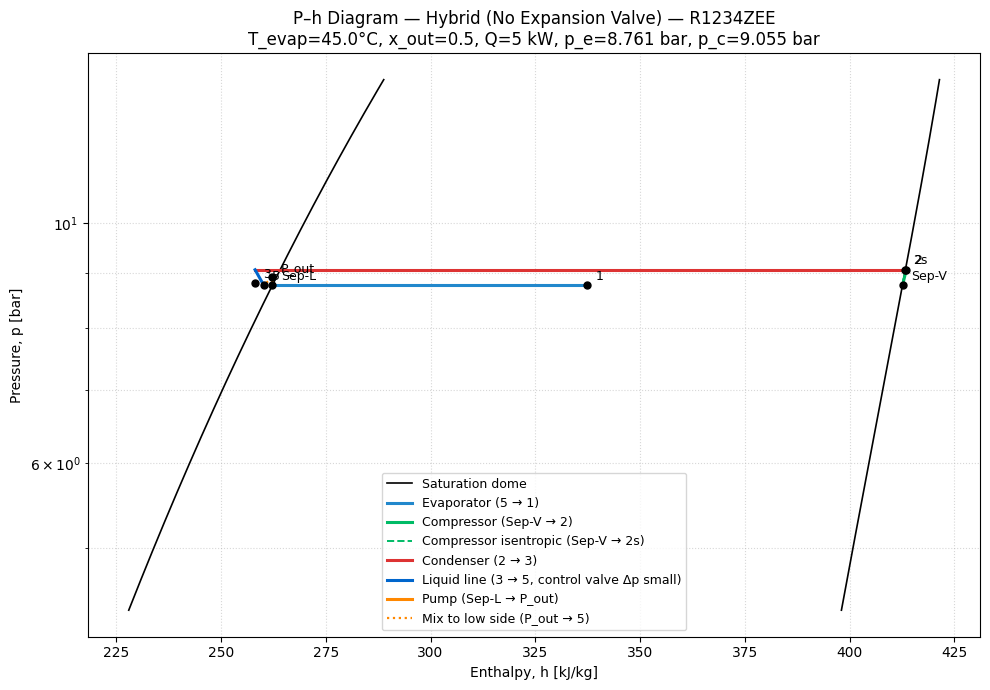

In [13]:
# -*- coding: utf-8 -*-
# Hybrid system (Separator + Small Compressor + Small Pump) — No Expansion Valve
# ------------------------------------------------------------------------------
# Flow (steady state, near-isobaric loop):
#   Evaporator → Separator:
#     • Vapor → Compressor (small lift) → Condenser (to subcooled liquid) → Liquid line (small Δp) → Mix (low side)
#     • Liquid → Pump (small) → Mix (low side)
#   Mix → Evaporator inlet (boiling happens only in evaporator)
#
# Key points:
#   • NO expansion/throttling device. The control valve meters liquid flow with SMALL Δp only.
#   • Compressor lift is only what’s needed to overcome vapor-side/condenser/liquid-line pressure drops.
#   • Separator ties low-side pressure at the evaporator temperature; receiver may vent vapor to suction so
#     extra vapor is sent to condenser and can be condensed (modeled implicitly by mass/energy balances).
#
# Outputs:
#   • Mass flow sized for 5 kW; compressor & pump power; COP_cooling = Q / (W_comp + W_pump)
#   • P–h diagram with ALL state points and transitions labeled
#   • State table: p [bar], T [°C], h [kJ/kg], x [-]
#
# Requirements: pip install CoolProp matplotlib
# If REFPROP is installed, the script will use it via CoolProp automatically.

import math
import numpy as np
import sys

PLOT_PH = True

try:
    import matplotlib.pyplot as plt
except Exception:
    PLOT_PH = False
    sys.stderr.write("[Info] matplotlib not available; skipping P–h plot.\n")

try:
    from CoolProp.CoolProp import PropsSI
except Exception:
    sys.stderr.write("CoolProp is required. Install with: pip install CoolProp\n")
    raise

# ---------------------
# USER INPUTS
# ---------------------
fluid = "R1234ZEE"                # e.g., "R1234ZEE", "R1234yf", "R245fa", "Ammonia", "CO2"
prefer_refprop = True          # Use REFPROP via CoolProp if available

# Evaporator outlet (sets low-side pressure via saturation)
T_evap_C = 45.0                 # <<< set your evaporator temperature (e.g., -5.0 or +5.0 °C)
x_evap_out = 0.50              # quality at evaporator/splitter outlet

# Target capacity
Q_cool_target_W = 5000.0       # 5 kW

# Subcooling at condenser outlet (keeps liquid single-phase into the low side)
DT_subcool_K = 3.0             # K

# Small control valve Δp (for metering only, no throttling/flash)
dp_cv_bar = 0.02               # bar (set ~0 if negligible)

# Efficiencies
eta_comp_is = 0.70             # compressor isentropic efficiency
eta_pump = 0.70                # pump hydraulic → shaft efficiency

# Elevation (evaporator above pump on liquid leg)
dz_liq_pump_m = +1.2           # m

# Geometry & roughness (adjust to your system)
# Vapor lines
L_suction = 2.0; D_suction = 0.012; eps_suction = 1.5e-5
L_discharge = 2.0; D_discharge = 0.012; eps_discharge = 1.5e-5
# Condenser (two-phase to saturated liquid)
L_cond = 10.0; D_cond = 0.010; eps_cond = 1.5e-5
# Condenser liquid line to mixer (carries only condensed flow ~ m_vap)
L_liq_cond2mix = 3.0; D_liq_cond2mix = 0.008; eps_liq_cond2mix = 1.5e-5
# Pumped liquid line (separator → mixer; carries m_liq)
L_liq_pump = 3.0; D_liq_pump = 0.008; eps_liq_pump = 1.5e-5
# Evaporator (reporting DP only)
L_evap = 8.0; D_evap = 0.010; eps_evap = 1.5e-5

# ---------------------
# Backend selection (REFPROP if available)
# ---------------------
def pick_backend(fluid_name: str, prefer_refprop=True):
    backend = fluid_name
    if prefer_refprop:
        try:
            _ = PropsSI("T","P",101325,"Q",0.5,"REFPROP::"+fluid_name)
            backend = "REFPROP::"+fluid_name
        except Exception:
            backend = fluid_name
    return backend

backend = pick_backend(fluid, prefer_refprop)
print(f"Using backend: {backend}")

# ---------------------
# Thermo helpers
# ---------------------
def st_TX(T_C, x):
    T_K = T_C + 273.15
    p = PropsSI("P","T",T_K,"Q",x,backend)
    h = PropsSI("H","T",T_K,"Q",x,backend)
    s = PropsSI("S","T",T_K,"Q",x,backend)
    return {"T":T_K,"p":p,"h":h,"s":s,"x":x}

def st_pQ(p, Q):
    T = PropsSI("T","P",p,"Q",Q,backend)
    h = PropsSI("H","P",p,"Q",Q,backend)
    s = PropsSI("S","P",p,"Q",Q,backend)
    return {"T":T,"p":p,"h":h,"s":s,"x":Q}

def st_pT(p, T_K):
    h = PropsSI("H","P",p,"T",T_K,backend)
    s = PropsSI("S","P",p,"T",T_K,backend)
    try: x = PropsSI("Q","P",p,"T",T_K,backend)
    except Exception: x = float("nan")
    return {"T":T_K,"p":p,"h":h,"s":s,"x":x}

def st_pS(p, s):
    T = PropsSI("T","P",p,"S",s,backend)
    h = PropsSI("H","P",p,"S",s,backend)
    try: x = PropsSI("Q","P",p,"S",s,backend)
    except Exception: x = float("nan")
    return {"T":T,"p":p,"h":h,"s":s,"x":x}

def st_pH(p, h):
    T = PropsSI("T","P",p,"H",h,backend)
    s = PropsSI("S","P",p,"H",h,backend)
    try: x = PropsSI("Q","P",p,"H",h,backend)
    except Exception: x = float("nan")
    return {"T":T,"p":p,"h":h,"s":s,"x":x}

def hL(p): return PropsSI("H","P",p,"Q",0.0,backend)
def hV(p): return PropsSI("H","P",p,"Q",1.0,backend)
def Tsat(p): return PropsSI("T","P",p,"Q",0.0,backend)
def rhoL(p): return PropsSI("D","P",p,"Q",0.0,backend)
def rhoV(p): return PropsSI("D","P",p,"Q",1.0,backend)
def muL(p):  return PropsSI("VISCOSITY","P",p,"Q",0.0,backend)
def muV(p):  return PropsSI("VISCOSITY","P",p,"Q",1.0,backend)

# ---------------------
# Hydraulics (Darcy–Weisbach), homogeneous two-phase model for reporting
# ---------------------
g = 9.80665
bar2Pa = 1e5

def haaland_f(Re, rel_eps):
    if Re < 1e-12: return 0.0
    if Re < 2300.0: return 64.0/Re
    A = (rel_eps/3.7)**1.11 + 6.9/Re
    return (-1.8*np.log10(A))**-2

def dp_friction_DW(m_dot, rho, mu, L, D, eps):
    A = 0.25*np.pi*D*D
    v = m_dot/(rho*A)
    Re = rho*v*D/max(mu,1e-12)
    f = haaland_f(Re, eps/D)
    dp = f*(L/D)*(rho*v*v/2.0)
    return dp, f, Re, v

def two_phase_mix_props(p, x):
    x = float(np.clip(x, 0.0, 1.0))
    rL, rV = rhoL(p), rhoV(p)
    mL, mV = muL(p), muV(p)
    rho_m = 1.0 / (x/rV + (1.0-x)/rL)
    mu_m  = mL*(1.0-x) + mV*x
    return rho_m, mu_m

def dp_two_phase_homogeneous(m_dot, p_in, p_out, x_in, x_out, L, D, eps, dz=0.0, N=60):
    ps = np.linspace(p_in, p_out, N)
    xs = np.linspace(x_in, x_out, N)
    A = 0.25*np.pi*D*D
    dp_fric = 0.0
    dp_stat = 0.0
    dL = L/max(N-1,1)
    dz_i = dz/max(N-1,1) if N>1 else dz
    for i in range(N-1):
        p_mid = 0.5*(ps[i]+ps[i+1])
        x_mid = 0.5*(xs[i]+xs[i+1])
        rho_m, mu_m = two_phase_mix_props(p_mid, x_mid)
        v = m_dot/(rho_m*A)
        Re = rho_m*v*D/max(mu_m,1e-12)
        f = haaland_f(Re, eps/D)
        dp_fric += f*(dL/D)*(rho_m*v*v/2.0)
        dp_stat += rho_m*g*dz_i
    return dp_fric+dp_stat, dp_fric, dp_stat

# ---------------------
# Core solver: for a given m_tot, find compressor discharge pressure p_c
# so that condenser+liquid line returns to low-side (no throttling).
# ---------------------
def find_pc_and_states(m_tot, T_evap_C, x_out, DT_sub, dp_cv_bar,
                       eta_comp_is,
                       L_cond, D_cond, eps_cond,
                       L_dis, D_dis, eps_dis,
                       L_liq_c2m, D_liq_c2m, eps_liq_c2m):
    # Low side (separator/evaporator)
    st1 = st_TX(T_evap_C, x_out)               # Evap OUT
    p_e = st1["p"]; h1 = st1["h"]
    st_sep_v = st_pQ(p_e, 1.0)                 # sat vapor
    st_sep_l = st_pQ(p_e, 0.0)                 # sat liquid
    hL_e = hL(p_e)

    m_vap = x_out * m_tot                      # vapor through compressor
    m_liq = (1.0 - x_out) * m_tot              # liquid through pump (not used here)

    # Small suction line DP (affects comp inlet pressure)
    rho_sv, mu_sv = rhoV(p_e), muV(p_e)
    # You can include suction line in m_vap path before compressor; here we omit for simplicity (tiny).
    dp_suct, f_suct, Re_suct, v_suct = 0.0, 0.0, 0.0, 0.0

    # Iterate p_c to close pressure balance to low side at mixer
    p_c = p_e + 0.2*bar2Pa
    tol = 50.0  # Pa
    for _ in range(20):
        # Compressor (isentropic + actual) from p_in = p_e - dp_suct to p_out = p_c
        p_in_comp = p_e - dp_suct
        h1v, s1v = st_sep_v["h"], st_sep_v["s"]
        st2s = st_pS(p_c, s1v)
        h2s = st2s["h"]
        h2 = h1v + (h2s - h1v)/max(eta_comp_is,1e-6)
        st2 = st_pH(p_c, h2)

        # Discharge line DP (comp out -> condenser in), properties near st2
        rho_d = PropsSI("D","P",p_c,"H",h2,backend)
        mu_d  = PropsSI("VISCOSITY","P",p_c,"H",h2,backend)
        dp_dis, f_dis, Re_dis, v_dis = dp_friction_DW(m_vap, rho_d, mu_d, L_dis, D_dis, eps_dis)
        p_cond_in = p_c - dp_dis

        # Condenser DP (two-phase from x=1 → 0; p falls from p_cond_in → p3)
        p3 = p_cond_in - 0.05*bar2Pa
        for _it in range(8):
            dp_cond, _, _ = dp_two_phase_homogeneous(m_vap, p_cond_in, p3, 1.0, 0.0, L_cond, D_cond, eps_cond, dz=0.0)
            p3_new = p_cond_in - dp_cond
            if abs(p3_new - p3) < 25.0:
                p3 = p3_new; break
            p3 = 0.5*(p3 + p3_new)

        # Subcooled condenser outlet at T3 = Tsat(p3) - DT_sub
        T3 = Tsat(p3) - DT_sub
        st3 = st_pT(p3, T3)
        h3 = st3["h"]

        # Liquid line from condenser to mixer (carries m_vap)
        p_ref = 0.5*(p3 + p_e); T_ref = 0.5*(Tsat(p3) + T3)
        rho_liq = PropsSI("D","P",p_ref,"T",T_ref,backend)
        mu_liq  = PropsSI("VISCOSITY","P",p_ref,"T",T_ref,backend)
        dp_liq_c2m, fL, ReL, vL = dp_friction_DW(m_vap, rho_liq, mu_liq, L_liq_c2m, D_liq_c2m, eps_liq_c2m)

        dp_cv = dp_cv_bar * bar2Pa
        p_mix = p3 - dp_liq_c2m - dp_cv
        err = p_mix - p_e
        if abs(err) < tol:
            return {
                "p_e": p_e, "p_c": p_c,
                "st1": st1, "st_sep_v": st_sep_v, "st_sep_l": st_sep_l,
                "st2s": st2s, "st2": st2, "st3": st3,
                "h3": h3, "dp_dis": dp_dis, "dp_cond": p_cond_in - p3, "dp_liq_c2m": dp_liq_c2m,
                "dp_cv": dp_cv, "m_vap": m_vap
            }
        # Relaxation update (increase p_c if p_mix < p_e)
        p_c -= 0.7*err

    raise RuntimeError("Failed to converge compressor discharge pressure p_c")

# ---------------------
# Outer iteration: adjust total mass flow to hit target Q_cool
# ---------------------
def solve_total(Q_target_W):
    # Initial guess for mass flow
    m_tot = 0.05  # kg/s
    for _ in range(15):
        # Inner solve: get p_c and key states for this m_tot
        inner = find_pc_and_states(
            m_tot, T_evap_C, x_evap_out, DT_subcool_K, dp_cv_bar,
            eta_comp_is,
            L_cond, D_cond, eps_cond,
            L_discharge, D_discharge, eps_discharge,
            L_liq_cond2mix, D_liq_cond2mix, eps_liq_cond2mix
        )
        p_e = inner["p_e"]; p_c = inner["p_c"]
        st1 = inner["st1"]; st3 = inner["st3"]
        h1 = st1["h"]; h3 = inner["h3"]; hL_e = hL(p_e)

        # Evaporator inlet enthalpy from mixing (no expansion): h5 = (1-x)*hL_e + x*h3
        h5 = (1.0 - x_evap_out)*hL_e + x_evap_out*h3
        st5 = st_pH(p_e, h5)

        # Cooling per kg
        q_evap = h1 - h5
        if q_evap <= 0:
            m_tot *= 0.5
            continue
        Q_calc = m_tot * q_evap
        if abs(Q_calc - Q_target_W) < 10.0:
            # compute compressor & pump powers, and pack results
            m_vap = inner["m_vap"]; m_liq = (1.0 - x_evap_out)*m_tot
            # Compressor power
            w_comp = inner["st2"]["h"] - inner["st_sep_v"]["h"]
            P_comp = m_vap * w_comp
            # Pump: separator liquid → mixer
            rho_liq_e = rhoL(p_e); mu_liq_e = muL(p_e)
            dp_f_pump, f_lp, Re_lp, v_lp = dp_friction_DW(m_liq, rho_liq_e, mu_liq_e, L_liq_pump, D_liq_pump, eps_liq_pump)
            dp_stat_pump = rho_liq_e * g * dz_liq_pump_m
            dp_pump = dp_f_pump + dp_stat_pump
            P_hyd = (m_liq / max(rho_liq_e,1e-9)) * dp_pump
            P_pump = P_hyd / max(eta_pump, 1e-6)
            COP = Q_calc / (P_comp + P_pump)

            # Evaporator DP (reporting): homogeneous model at p_e from x5 → x_out
            x5 = float(np.clip((h5 - hL_e)/max(hV(p_e) - hL_e, 1e-9), 0.0, 1.0))
            dp_evap_total, dp_evap_f, dp_evap_stat = dp_two_phase_homogeneous(
                m_tot, p_e, p_e, x5, x_evap_out, L_evap, D_evap, eps_evap, dz=0.0, N=60
            )

            # Pump outlet state (small pressure rise; enthalpy ~ unchanged)
            stP_out = {"p": p_e + dp_pump, "T": st_TX(T_evap_C, 0.0)["T"], "h": hL_e, "s": float("nan"), "x": 0.0}

            # Return results
            out = {
                "m_tot": m_tot, "m_vap": m_vap, "m_liq": m_liq,
                "Q_cool_W": Q_calc, "COP": COP,
                "P_comp_W": P_comp, "P_pump_W": P_pump,
                "dp_pump": dp_pump,
                "dp_evap_total": dp_evap_total,
                "dp_suction": 0.0, "dp_discharge": inner["dp_dis"],
                "dp_condenser": inner["dp_cond"], "dp_liq_cond2mix": inner["dp_liq_c2m"], "dp_cv": inner["dp_cv"],
                "states": {
                    "1 Evap OUT (mix)": st1,
                    "Sep-V (to compressor)": inner["st_sep_v"],
                    "2s Compressor OUT (isentr.)": inner["st2s"],
                    "2 Compressor OUT": inner["st2"],
                    "3 Condenser OUT (subcooled)": st3,
                    "Sep-L (to pump)": inner["st_sep_l"],
                    "P_out Pump OUT (liquid)": stP_out,
                    "5 Evap IN (mix)": st5
                },
                "p_e": p_e, "p_c": p_c, "h5": h5, "x5": x5, "h3": h3
            }
            return out

        # Update mass flow (damped proportional)
        if Q_calc <= 0:
            m_tot *= 1.2
        else:
            m_tot *= max(0.3, min(3.0, Q_target_W / max(Q_calc, 1e-9)))**0.5

    raise RuntimeError("Failed to meet target cooling within iteration limit")

# ---------------------
# Solve and report
# ---------------------
res = solve_total(Q_cool_target_W)

# KPIs
print("\n=== Hybrid (No Expansion Valve) — KPIs ===")
print(f"Fluid                       : {fluid} (backend: {backend})")
print(f"T_evap                      : {T_evap_C:.2f} °C (p_e = {res['p_e']/1e5:.3f} bar), x_out = {x_evap_out:.3f}")
print(f"p_c (discharge)            : {res['p_c']/1e5:.3f} bar (small lift to cover DPs)")
print(f"Cooling delivered           : {res['Q_cool_W']/1000.0:.3f} kW")
print(f"Mass flows (total / vapor / liquid): {res['m_tot']:.5f} / {res['m_vap']:.5f} / {res['m_liq']:.5f} kg/s")
print(f"Compressor power            : {res['P_comp_W']:.2f} W")
print(f"Pump Δp (liq leg)          : {res['dp_pump']/1e5:.4f} bar")
print(f"Pump power                  : {res['P_pump_W']:.2f} W")
print(f"COP_cooling                : {res['COP']:.3f}")

print("\n=== Pressure drops (computed) ===")
print(f"Discharge line Δp          : {res['dp_discharge']/1e5:.4f} bar")
print(f"Condenser Δp (two-phase)   : {res['dp_condenser']/1e5:.4f} bar")
print(f"Cond→Mix liquid line Δp    : {res['dp_liq_cond2mix']/1e5:.4f} bar")
print(f"Control valve Δp (set)     : {res['dp_cv']/1e5:.4f} bar")
print(f"Evaporator Δp (report)     : {res['dp_evap_total']/1e5:.4f} bar")

# State table
def fmt_state(name, st):
    p_bar = st["p"]/1e5
    T_C = st["T"] - 273.15
    h_kJkg = st["h"]/1e3
    x = st.get("x", float("nan"))
    xs = "N/A" if (not np.isfinite(x)) else f"{x:0.4f}"
    return f"{name:<28s} p={p_bar:8.3f} bar  T={T_C:8.3f} °C  h={h_kJkg:9.3f} kJ/kg  x={xs}"

print("\n=== State Points ===")
for k, v in res["states"].items():
    print(fmt_state(k, v))

# ---------------------
# P–h diagram (all states & labeled transitions)
# ---------------------
if PLOT_PH:
    try:
        # Saturation dome
        p_min = max(PropsSI("P_MIN","",0,"",0,backend), min(res["p_e"], res["p_c"])*0.5)
        p_max = min(PropsSI("P_MAX","",0,"",0,backend), max(res["p_e"], res["p_c"])*1.5)
        p_sat = np.geomspace(max(p_min,1e3), p_max, 350)
        hL_sat = np.array([hL(pi) for pi in p_sat]); hV_sat = np.array([hV(pi) for pi in p_sat])

        st = res["states"]
        st1 = st["1 Evap OUT (mix)"]
        st2 = st["2 Compressor OUT"]
        st2s = st["2s Compressor OUT (isentr.)"]
        st3 = st["3 Condenser OUT (subcooled)"]
        st5 = st["5 Evap IN (mix)"]
        st_sep_v = st["Sep-V (to compressor)"]
        st_sep_l = st["Sep-L (to pump)"]
        stP_out = st["P_out Pump OUT (liquid)"]

        # Evaporator segment at p_e (5 -> 1), x: x5 -> x_out
        N_ev = 60
        x5 = res["x5"]; p_e = res["p_e"]; p_c = res["p_c"]
        xs = np.linspace(x5, x_evap_out, N_ev)
        hs = [hL(p_e) + xi*(hV(p_e)-hL(p_e)) for xi in xs]
        ps = np.full(N_ev, p_e)

        plt.figure(figsize=(10,7))
        plt.plot(hL_sat/1e3, p_sat/1e5, 'k-', lw=1.2, label="Saturation dome")
        plt.plot(hV_sat/1e3, p_sat/1e5, 'k-', lw=1.2)

        # Evaporator
        plt.plot(np.array(hs)/1e3, ps/1e5, color="#28c", lw=2.2, label="Evaporator (5 → 1)")

        # Compressor (actual & isentropic)
        plt.plot([st_sep_v["h"]/1e3, st2["h"]/1e3], [p_e/1e5, p_c/1e5], color="#0b6", lw=2.2, label="Compressor (Sep-V → 2)")
        plt.plot([st_sep_v["h"]/1e3, st2s["h"]/1e3], [p_e/1e5, p_c/1e5], color="#0b6", lw=1.4, ls="--", label="Compressor isentropic (Sep-V → 2s)")

        # Condenser (2 → 3) approximately horizontal at p_c
        N_cd = 40
        h_cd = np.linspace(st2["h"], st3["h"], N_cd)
        p_cd = np.full(N_cd, p_c)
        plt.plot(h_cd/1e3, p_cd/1e5, color="#d33", lw=2.2, label="Condenser (2 → 3)")

        # Liquid line (3 → 5) — small Δp, negligible throttling (no flash)
        plt.plot([st3["h"]/1e3, st5["h"]/1e3], [p_c/1e5, p_e/1e5], color="#06c", lw=2.2, label="Liquid line (3 → 5, control valve Δp small)")

        # Pump (Sep-L → P_out), small lift at ~const h
        plt.plot([st_sep_l["h"]/1e3, stP_out["h"]/1e3], [st_sep_l["p"]/1e5, stP_out["p"]/1e5],
                 color="#f80", lw=2.2, label="Pump (Sep-L → P_out)")

        # Mixing representation: P_out to 5 (pressure relaxation at ~const h)
        plt.plot([stP_out["h"]/1e3, st5["h"]/1e3], [stP_out["p"]/1e5, p_e/1e5],
                 color="#f80", lw=1.6, ls=":", label="Mix to low side (P_out → 5)")

        # Markers and labels
        markers = {
            "1": st1, "Sep-V": st_sep_v, "2": st2, "2s": st2s, "3": st3, "Sep-L": st_sep_l, "P_out": stP_out, "5": st5
        }
        for tag, spt in markers.items():
            plt.plot(spt["h"]/1e3, spt["p"]/1e5, 'ko', ms=5)
            plt.annotate(tag, (spt["h"]/1e3, spt["p"]/1e5), textcoords="offset points", xytext=(6,4), fontsize=9)

        plt.yscale("log")
        plt.xlabel("Enthalpy, h [kJ/kg]")
        plt.ylabel("Pressure, p [bar]")
        plt.title(f"P–h Diagram — Hybrid (No Expansion Valve) — {fluid}\n"
                  f"T_evap={T_evap_C}°C, x_out={x_evap_out}, Q=5 kW, p_e={p_e/1e5:.3f} bar, p_c={p_c/1e5:.3f} bar")
        plt.grid(True, which="both", ls=":", alpha=0.5)
        plt.legend(loc="best", fontsize=9)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Plot skipped due to error: {e}]")


### Other considerations

#### Surge and Choke Margin Challenges in High-Speed Turbocompressors

- **Surge Margin**
  Surge occurs when the compressor cannot maintain stable flow at low mass flow rates.
  At e.g. **60,000 RPM**, the operating map becomes very narrow, making it difficult to keep the system away from surge during transient conditions or load changes.

- **Choke Margin**
  Choke happens when the compressor reaches its maximum flow capacity and cannot pass more air without a sharp drop in efficiency.
  With **large flow rates**, the choke line is close to the design point, leaving little room for safe operation at high speeds.

- **Why It’s a Challenge**
  - High rotational speed reduces the width of the stable operating range.
  - Large flow combined with small pressure ratio means the compressor map is flat and sensitive to disturbances.
  - Control systems must react extremely fast to avoid surge or choke during rapid changes in demand.

**Key Takeaway:**
Maintaining adequate surge and choke margins at 60k RPM requires precise aerodynamic design and advanced control strategies.
#### Compressor Operation Envelop

**Range:**
$$
\text{range} = \left( \frac{\dot{V}_{ch} - \dot{V}_{st}}{\dot{V}_{ch}} \right)
$$

**Stability:**
$$
\text{stability} = \left( \frac{\dot{V}_{rp} - \dot{V}_{st}}{\dot{V}_{rp}} \right)
$$

**Choke Margin:**
$$
\text{choke margin} = \left( \frac{\dot{V}_{ch}}{\dot{V}_{rp}} \right)
$$

**Turn Down:**
$$
\text{turn down} = \left( \frac{\dot{V}_{rp} - \dot{V}_{td}}{\dot{V}_{rp}} \right)
$$

**Surge Margin:**
$$
\text{surge margin} = \left( \frac{\pi_{sm} - \pi_{rp}}{\pi_{rp}} \right)
$$

**Head Rise to Surge:**
$$
\text{head rise to surge} = \left( \frac{y_{12,st} - y_{12,rp}}{y_{12,rp}} \right)
$$


![Pressue lift vs. Flow - - range where surge and choke occure ](IMG/PresLiftvsFlowTurbo.svg)


<div style="background-color:black; zoom:150%; padding:20px;">
    <table>
        <tr>
            <td style="text-align:center; color:white;">
                <img src="IMG/sample-compressor-map1.png" alt="Image 1" width = "250"      </td>
            <td style="text-align:center; color:white;">
                <img src="IMG/Performance-characteristic-map-for-an-axial-compressor.png" alt="Image 2" width="300"><</td>
        </tr>
    </table>
</div>

##### From TurboSelect

<div style="background-color:black; zoom:150%; padding:20px;">
    <table>
        <tr>
            <td style="text-align:center; color:white;">
                <img src="IMG/TurboSelect - Boundary Map.png" alt="Image 1" width = "350"      </td>
            <td style="text-align:center; color:white;">
                <img src="IMG/TurboSelect -  Compressor Operating Map.png" alt="Image 2" width="400"><</td>
        </tr>
    </table>
</div>